In [1]:
from __future__ import division
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import get_writer
from PIL import Image
import astra
from src.measurements.projections import *
import matplotlib.pyplot as plt
from src.reconstruction_algs.DART import *

<h4>Create 2D phantom</h4>

Original phantom


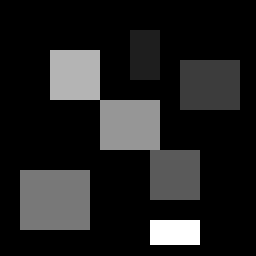

In [2]:
img_width, img_height = 256, 256

# create a simple phantom
phantom_data = np.full(fill_value=0,shape=(img_width, img_height))
phantom_data[30:80, 130: 160] = 30 # top right, darkest
phantom_data[60:110, 180:240] = 60  # top right, brighter of the two
phantom_data[150:200, 150:200] = 90  # bottom right, gray
phantom_data[170:230, 20:90] = 120  # bottom left one
phantom_data[100:150, 100:160] = 150  # middle one
phantom_data[50:100, 50:100] = 180  # top left
phantom_data[220:245,150:200] = 255 # bottom right, brigh white
phantom_data = phantom_data.astype(np.uint8)
print("Original phantom")
Image.fromarray(phantom_data)

<h4>Creating phantom volume and add to astra wrapper</h4>

In [3]:
vol_geom = astra.creators.create_vol_geom([img_width,img_height])
phantom_id = astra.data2d.create('-vol', vol_geom, data=phantom_data)

<h4>Create projections</h4>

In [4]:
n_projections = 180
detector_rows = img_width
detector_cols = img_height
detector_pixel_size = 1.0
angles = np.linspace(0, np.pi, n_projections)

proj_geom = astra.create_proj_geom('parallel', detector_pixel_size, detector_rows, angles)
projector = astra.create_projector('linear', proj_geom, vol_geom)
proj_id, projections = astra.creators.create_sino(phantom_id, projector)

In [5]:
projections.shape

(180, 256)

In [6]:
"""output_dir = 'dataset/'

# Save projections.
if not isdir(output_dir):
    mkdir(output_dir)
projections = np.round(projections * 65535).astype(np.uint8)
for i in range(n_projections):
    projection = projections[i]
    with get_writer(join(output_dir, 'proj%04d.png' %i)) as writer:
        writer.append_data(projection, {'compress': 9})"""

"output_dir = 'dataset/'\n\n# Save projections.\nif not isdir(output_dir):\n    mkdir(output_dir)\nprojections = np.round(projections * 65535).astype(np.uint8)\nfor i in range(n_projections):\n    projection = projections[i]\n    with get_writer(join(output_dir, 'proj%04d.png' %i)) as writer:\n        writer.append_data(projection, {'compress': 9})"

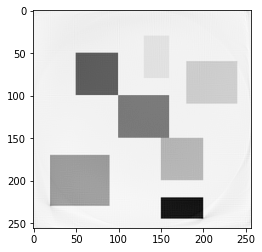

In [7]:
# create astra phantom
vol_geom = astra.creators.create_vol_geom([img_width,img_height])
phantom_id = astra.data2d.create('-vol', vol_geom, data=phantom_data)

projector_id, sino_id, sinogram = project_from_2D(phantom_id, 
                                                    vol_geom,250,1.0)

# create empty vessel
reconstruction_id = astra.data2d.create('-vol', vol_geom, data=0)

alg_cfg = astra.astra_dict('SART')
alg_cfg['ProjectorId'] = projector_id
alg_cfg['ProjectionDataId'] = sino_id
alg_cfg['ReconstructionDataId'] = reconstruction_id

algorithm_id = astra.algorithm.create(alg_cfg)
astra.algorithm.run(algorithm_id, 10000)
reconstruction = astra.data2d.get(reconstruction_id)
plt.imshow(reconstruction, cmap='Greys')

In [8]:
dart = DART((img_width,img_width))

In [10]:
reconstr_id, reconstr = dart.SART(projector_id,sino_id,iters=200)

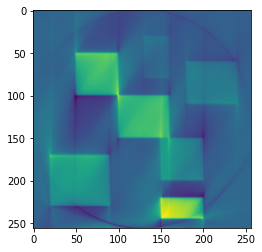

In [11]:
plt.imshow(reconstr)